https://musicinformationretrieval.com/stft.html
https://music.stackexchange.com/questions/34402/understanding-midi-files


In [25]:
%matplotlib inline
import librosa as lb
import librosa.display
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
import numpy as np
import re
import os,glob
from importlib import import_module
import time
import pretty_midi
import IPython.display as ipd
import pandas as pd

In [2]:
import torch
from torch.utils import data
from torch import nn
import math
from torch.utils.data import Dataset
from torch.nn import DataParallel
from torch.backends import cudnn
from torch.utils.data import DataLoader
from torch import optim
from torch.autograd import Variable

In [3]:
MIDInotes=[21,108]
sr=44100
bins_per_octave=36
n_octave=7
n_bins=n_octave*bins_per_octave
n_workers=0
start_lr=0.01
weight_decay=1e-4
nb_epochs=1
save_freq=1
win_width=32  
batch_size=8  
kernel_size=7

In [43]:
audio_file='audio/piano_A.mp3'
midi_file='audio/piano_A.mid'
x, _ = librosa.load(audio_file, sr=sr)
kernel_size=7
win_width=16
print(sr)
ipd.Audio(audio_file)

44100


Number of samples = 434304, sr = 44100. Total duration = samples/sr
Window size for CQT = #samples/CQT.shape[0] = ~512 (or each frame is of 512 samples, or the window size)
That's why we have 849 data points in the CQT.
Also second duration of each frame is 512/44100 = ~ 0.0116 second or close to 12 millisecond is the granularity at which each frame is transformed to a CQT spectrum.



In [44]:
def plot_piano_roll(pm, start_pitch, end_pitch, fs=100):
    librosa.display.specshow(pm.get_piano_roll(fs)[start_pitch:end_pitch],
                             hop_length=1, sr=fs, x_axis='time', y_axis='cqt_note',
                             fmin=pretty_midi.note_number_to_hz(start_pitch))

In [47]:
def analyse_audio(audio_file, midi_file):
    x, _ = librosa.load(audio_file, sr=sr)
    print("Music file length=%s, sampling_rate=%s" % (x.shape[0],sr))
    plt.figure(figsize=(14, 5))
    plt.title('Music Sample Waveplot')
    librosa.display.waveplot(x, sr=sr)
    x_stft_spectrum = lb.stft(x, n_fft=1024,hop_length=512,center=True, dtype=np.complex64)
    x_stft = librosa.amplitude_to_db(abs(x_stft_spectrum))
    plt.figure(figsize=(14, 5))
    librosa.display.specshow(lb.amplitude_to_db(x_stft, ref=np.max), sr=sr, fmin=lb.note_to_hz('A0'), x_axis='time', y_axis='linear',cmap='coolwarm')
    plt.title('Power spectrogram')
    plt.colorbar(format='%+2.0f dB')
    plt.tight_layout()
    plt.figure(figsize=(14, 5))
    x_cqt = np.abs(librosa.cqt(x, sr=sr, bins_per_octave=bins_per_octave, n_bins=n_bins, fmin=lb.note_to_hz('A0')))
    librosa.display.specshow(librosa.amplitude_to_db(x_cqt, ref=np.max), sr=sr, x_axis='time', y_axis='cqt_note',cmap='coolwarm')
    print("CQT Matrix shape", x_cqt.shape)
    plt.colorbar(format='%+2.0f dB')
    plt.title('Constant-Q power spectrum')
    plt.tight_layout()
    n_frames=x_cqt.shape[1]
    midi_data = pretty_midi.PrettyMIDI(midi_file)
    plt.figure(figsize=(12, 4))
    plot_piano_roll(midi_data, 24, 84)
    print('There are {} time signature changes'.format(len(midi_data.time_signature_changes)))
    print('There are {} instruments'.format(len(midi_data.instruments)))
    print('Instrument 1 has {} notes'.format(len(midi_data.instruments[0].notes)))
    pianoRoll = midi_data.instruments[0].get_piano_roll(fs=n_frames * 44100. / len(x))
    midi_mat = (pianoRoll[MIDInotes[0]:MIDInotes[1] + 1, :n_frames] > 0)
    print("MIDI Matrix shape", midi_mat.shape)
    plt.figure()
    librosa.display.specshow(midi_mat, sr=sr, bins_per_octave=12, fmin=lb.note_to_hz('A0'), x_axis='time', y_axis='cqt_note')
    n_pitch_frame=np.sum(midi_mat, axis=1)
    print(n_pitch_frame)
    plt.bar(range(MIDInotes[0],MIDInotes[1]+1),n_pitch_frame/np.sum(n_pitch_frame).astype(np.float))
    plt.xticks(range(MIDInotes[0],MIDInotes[1]+1,12), lb.midi_to_note(range(MIDInotes[0], MIDInotes[1]+1,12)))
    plt.xlabel('Midi note')
    plt.ylabel('Note probability')

Music file length=434304, sampling_rate=44100
CQT Matrix shape (252, 849)
There are 1 time signature changes
There are 1 instruments
Instrument 1 has 1 notes
MIDI Matrix shape (88, 846)
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0 804   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]


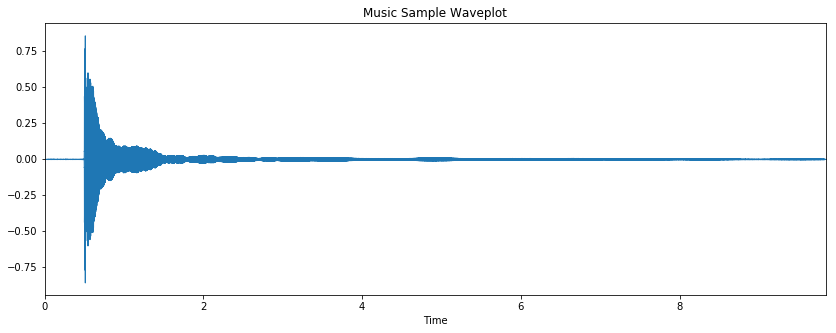

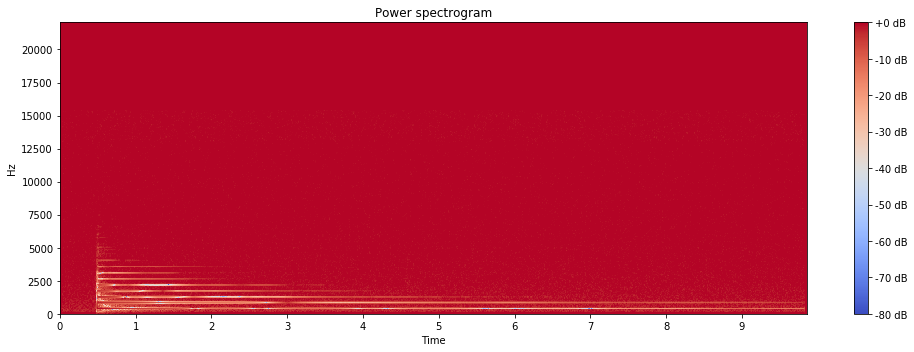

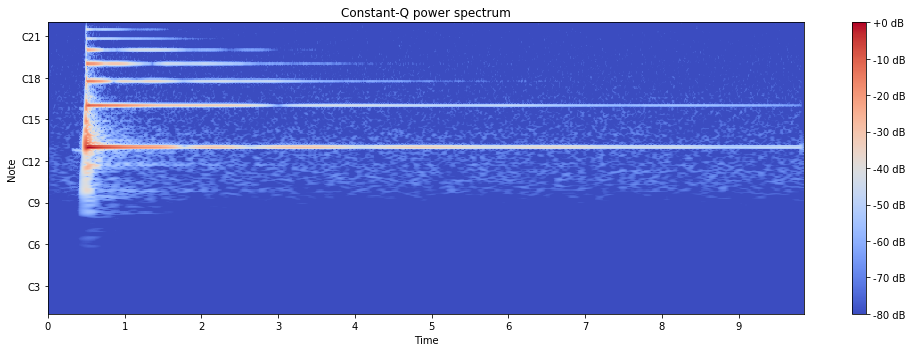

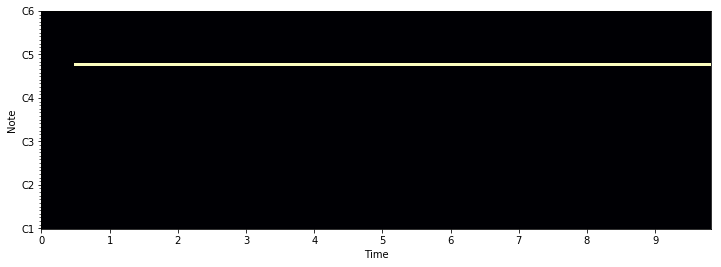

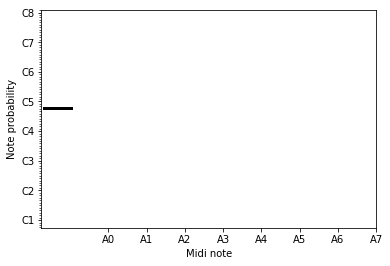

In [48]:
# analyse_audio(audio_file, midi_file)

Module to PreProcess data and place files in a folder called preprocessed_data with train, test and validate folders..

Module to PreProcess data and place split frames in folder, for data_loader to pick up

In [50]:
label=np.transpose(midi_mat)
cqt = np.transpose(x_cqt)
if label.shape[0]<cqt.shape[0]: 
    cqt=cqt[:label.shape[0],:]
print(label.shape,cqt.shape)
file_path='processed_data/files/'+audio_file.split('/')[1].split('.')[0]
train_path='processed_data/train/'+audio_file.split('/')[1].split('.')[0]
np.save(file_path + '_cqt.npy', cqt)
np.save(file_path + '_label.npy', label)
nsamples=cqt.shape[0]
win_width=32
numwin=math.floor(nsamples/win_width)
for i in range(numwin):
    part_matrix_cqt = cqt[i*win_width:(i+1)*win_width,:]
    np.save(train_path+'_'+str(i)+'_cqt',part_matrix_cqt)
    part_matrix_label = label[i*win_width:(i+1)*win_width,:]
    np.save(train_path+'_'+str(i)+'_label',part_matrix_label)
    print(i,part_matrix_cqt.shape,part_matrix_label.shape)

NameError: name 'midi_mat' is not defined

In [51]:
train_folder='preprocessed_data/train/'
val_folder='preprocessed_data/val/'
test_folder='preprocessed_data/test/'
data_dir='preprocessed_data'
result_dir='result'

In [16]:
class data_loader(Dataset):
    def __init__(self, data_dir, win_width, kernel_size, overlap=True, phase='train'):
        assert (phase == 'train' or phase == 'val' or phase == 'test')
        self.phase = phase
        filelist= glob.glob(os.path.join(data_dir,phase)+'/*') #namelist of CQT files and label files
#         print(phase+'filelist:')
#         print(filelist)
        CQT_name=[f for f in filelist if (f[-7:-4]=='CQT')]
        self.input=[]
        self.nb_sample=[]

        for i in CQT_name:
            self.input.append(np.expand_dims(cut(np.load(i),win_width,kernel_size,overlap=overlap),axis=1))   # 64s,no need to paralellize, I/O is limited ,246s with 5 workers
            self.nb_sample.append(self.input[-1].shape[0])
#         print(phase+'data loaded')
        label_name=[f[:-7]+'label.npy' for f in CQT_name]
        self.label=[]
        for i in label_name:
            self.label.append(np.expand_dims(cut(np.load(i),win_width,kernel_size,overlap=False).transpose(0,2,1),axis=3))
#         print(phase+'label loaded')
        print("Phase:"+phase+" files loaded: ",len(filelist), " samples",len(self.input), "labels", len(self.label))

    def __getitem__(self,idx):
        nb_list, sub_nb = index(idx,self.nb_sample)
        return torch.from_numpy(self.input[nb_list][sub_nb].astype(np.float32)),torch.from_numpy(self.label[nb_list][sub_nb].astype(np.float32))   #(1,106,252)/(1,100,88)

    def __len__(self):
        return sum(self.nb_sample)

def cut(matrix,win_width,kernel_size,overlap=True,axis=0):  #
    l=matrix.shape[0]
    cut_matrix=[]
    nb_win=math.floor(l/win_width)  
    if not overlap:
        for i in range(nb_win):
            cut_matrix.append(matrix[i*win_width:(i+1)*win_width,:])
    else:
        w=matrix.shape[1]
        matrix_1=np.concatenate([np.zeros([math.floor(kernel_size/2),w]),matrix,np.zeros([math.floor(kernel_size/2),w])],axis=0)  #padding
        cut_matrix = []
        for i in range(nb_win):
            cut_matrix.append(matrix_1[i * win_width:(i + 1) * win_width+kernel_size-1,:])    
    cut_matrix = np.asarray(cut_matrix)
    return cut_matrix

def index(idx,nb_sample):
    l=len(nb_sample)
    accum_nb =0
    nb_list=0
    sub_nb=0
    for i in range(l):
        accum_nb+=nb_sample[i]
        if idx < accum_nb:
            nb_list, sub_nb= i, idx+nb_sample[i]-accum_nb
            break
    return nb_list,sub_nb

In [32]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.maxpool = nn.MaxPool2d(kernel_size=(1,3), stride=(1,3), return_indices=False)

        self.conv1= nn.Sequential(
            nn.Conv2d(1, 50, kernel_size=(5,25), stride=1),
            nn.BatchNorm2d(50),
            nn.ELU(inplace=True))
        self.conv2 = nn.Sequential(
            nn.Conv2d(50, 50, kernel_size=(3,5), stride=1),
            nn.BatchNorm2d(50),
            nn.ELU(inplace=True))
        self.fc1 = nn.Sequential(
            nn.Linear(in_features=38400,  out_features=9600),
            nn.ELU(inplace=True),
            nn.Dropout3d(p=0.5, inplace=False))
        self.fc2 = nn.Sequential(
            nn.Linear(in_features=9600,  out_features=4800),
            nn.ELU(inplace=True),
            nn.Dropout3d(p=0.5, inplace=False))
        self.fc3 = nn.Linear(in_features=4800,  out_features=32*88)

    def forward(self, x):
#         print("1.",x.shape)
        x = self.conv1(x)
#         print("2.",x.shape)
        x = self.maxpool(x)
#         print("3.",x.shape)
        x = self.conv2(x)  
#         print("4.",x.shape)
        x = self.maxpool(x)
#         print("5.",x.shape)
        x = x.view(-1, 38400)
#         print("6.",x.shape)
        x = self.fc1(x)
#         print("7.",x.shape)
        x = self.fc2(x)
#         print("8.",x.shape)
        x = self.fc3(x)
#         print("9.",x.shape)
        x = x.view(-1, 88, 32, 1)
#         print("10.",x.shape)
        return x


class Loss(nn.Module):
    def __init__(self, num_hard=0):
        super(Loss, self).__init__()

        self.classify_loss = nn.BCEWithLogitsLoss() 
    def forward(self, output, labels, train=True):
        loss = self.classify_loss(output,labels)
        pos = (torch.sigmoid(output) >= 0.5).type(torch.FloatTensor)
        pos_recall=labels.sum()
        pos_precision=pos.sum()
        TP=(pos*labels).sum()
        print("pos",pos.size(), "labels",labels.size())
        return [loss, TP.item(), pos_precision.item(), pos_recall.item()] 

def get_model():
    net = Net()
    loss = Loss()
    return net, loss

In [33]:
net, loss= get_model()
net = DataParallel(net) 

In [34]:
dataset=data_loader(data_dir,win_width, kernel_size, overlap=True,phase='train')
train_loader = DataLoader(
        dataset,
        batch_size = batch_size,
        shuffle = True,
        num_workers = n_workers,
        pin_memory=True)   

dataset=data_loader(data_dir, win_width, kernel_size, overlap=True,phase='val')
val_loader = DataLoader(
        dataset,
        batch_size = batch_size,
        shuffle = False,
        num_workers = n_workers,
        pin_memory=True)

dataset=data_loader(data_dir, win_width, kernel_size, overlap=True,phase='test')
test_loader = DataLoader(
        dataset,
        batch_size = batch_size,
        shuffle = False,
        num_workers = n_workers,
        pin_memory=False)

train files loaded:  4  samples 2 labels 2
val files loaded:  4  samples 2 labels 2
test files loaded:  2  samples 1 labels 1


In [35]:
optimizer = optim.Adam(
        net.parameters(),
        start_lr,
        weight_decay = weight_decay)

In [36]:
def get_lr(epoch,nb_epochs,start_lr):
    if epoch <= nb_epochs * 0.5:
        lr = start_lr
    elif epoch <= nb_epochs * 0.8:
        lr = 0.1 * start_lr
    else:
        lr = 0.01 * start_lr
    return lr

In [37]:
def train(data_loader, net, loss, epoch, optimizer, get_lr, save_freq, save_dir, nb_epochs, start_lr):
    start_time = time.time()

    net.train()
    lr = get_lr(epoch,nb_epochs,start_lr)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

    metrics = []

    for i, (data, target) in enumerate(data_loader):
        data = Variable(data)
        target = Variable(target)

        output = net(data)
        loss_output = loss(output,target)
        optimizer.zero_grad()
        loss_output[0].backward()
        optimizer.step()

        loss_output[0] = loss_output[0].item()
        metrics.append(loss_output)

    if epoch % save_freq == 0:
        state_dict = net.module.state_dict()
        for key in state_dict.keys():
            state_dict[key] = state_dict[key].cpu()

        torch.save({
            'epoch': epoch,
            'save_dir': save_dir,
            'state_dict': state_dict
            },
            os.path.join(save_dir, '%03d.ckpt' % epoch))

    end_time = time.time()
    metrics = np.asarray(metrics, np.float32)
    print('Epoch %03d (lr %.5f),time %3.2f' % (epoch, lr,end_time - start_time))  
    TP=np.sum(metrics[:, 1])
    Precision=TP/np.sum(metrics[:, 2])
    Recall=TP/np.sum(metrics[:, 3])
    Fscore=2*Precision*Recall/(Precision+Recall)
    print('Train:　loss %2.4f, Framewise Precision %3.2f,Recall %3.2f, F-score %3.2f' % (np.mean(metrics[:,0]),Precision,Recall,Fscore))
    

In [39]:
def validate(data_loader, net, loss):
    start_time = time.time()

    net.eval()

    metrics = []
    for i, (data, target) in enumerate(data_loader):
        data = Variable(data, volatile=True)
        target = Variable(target, volatile=True)

        output = net(data)
        loss_output = loss(output, target, train=False)

        loss_output[0] = loss_output[0].item()
        metrics.append(loss_output)
    end_time = time.time()

    metrics = np.asarray(metrics, np.float32)
    TP=np.sum(metrics[:, 1])
    Precision=TP/np.sum(metrics[:, 2])
    Recall=TP/np.sum(metrics[:, 3])
    Fscore=2*Precision*Recall/(Precision+Recall)
    print('Validation: Loss %2.4f,Framewise Precision %3.2f,Recall %3.2f, F-score %3.2f' % (np.mean(metrics[:,0]),Precision,Recall,Fscore))

In [40]:
if __name__=='__main__':
    start_epoch=0
    for epoch in range(start_epoch,nb_epochs):
        train(train_loader, net, loss, epoch, optimizer, get_lr, save_freq, save_dir, nb_epochs, start_lr)
        validate(val_loader, net, loss)

pos torch.Size([8, 88, 32, 1]) labels torch.Size([8, 88, 32, 1])


RuntimeError: $ Torch: not enough memory: you tried to allocate 1GB. Buy new RAM! at ..\aten\src\TH\THGeneral.cpp:204

In [31]:
train_df

""


In [41]:
correct = 0
total = 0
for i, (data, target) in enumerate(test_loader):
        data = Variable(data, volatile=True)
        target = Variable(target, volatile=True)
        output = net(data)
        output = (output >= 0.5).type(torch.FloatTensor)
        total += target.numel()                   # Increment the total count
        correct += (output == target).sum()     # Increment the correct count

print("Percentage:",correct.item()/total)

C:\Users\SUMIT\AppData\Local\conda\conda\envs\my_root\lib\site-packages\ipykernel_launcher.py:4: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  after removing the cwd from sys.path.
C:\Users\SUMIT\AppData\Local\conda\conda\envs\my_root\lib\site-packages\ipykernel_launcher.py:5: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  """


Percentage: 0.5162123033216783


In [41]:
x = torch.ones(8, 88, 32, 1)
y = torch.ones(8, 88, 32, 1)

In [32]:
x = torch.flatten(x)
y = torch.flatten(y)

In [9]:
x.numel()

22528

In [45]:
correct = (x*y)

In [47]:
correct.size()

torch.Size([8, 88, 32, 1])